## Face Verifacation


## connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### import dependencies


In [3]:
#importing packages
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
#impoting tensorflow dependencies - functional api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### set GPU Growth

In [2]:
# avoid Out Of Memory Error by setting GPU memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')#getting all gpus
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
print(tf.config.list_physical_devices())
tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


False

### Create Folder Sctructures


In [7]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
#make the directory using paths
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Getting our dataset


In [9]:
#http://vis-www.cs.umass.edu/lfw/#download
#uncompress tar gz labelled faces in wild dataset
!tar -xf lfw.gz

In [10]:
#Move LFW images to the repository data/negative
for directory in os.listdir('lfw'):#getting all directories
    for file in os.listdir(os.path.join('lfw', directory)):#loop in all files
        EXIST_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EXIST_PATH, NEW_PATH)# Move everything in new path


### Collect positive data from webcam


In [ ]:
#import uuid because we need to assign unique names for images
import uuid
#Established a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #cut down image to 250pxa * 250px (the size of our dataset)
    frame = frame[120:120+250, 200:200+250, :]

    #collect images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #show frame to screen
    cv2.imshow('image', frame)
    #Breaking after press q
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Get image directory

In [11]:
#get 300 image path from 3 folders
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)
# make iterator
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next()) # call next object

b'data/anchor/c36cecee-3f31-11ee-aa2a-3c7c3f514206.jpg'


### preprocess ( Scale and Resize)

In [4]:
def preprocess(file_path):
    #read file from path
    byte_image = tf.io.read_file(file_path)
    #Load real image
    img = tf.io.decode_jpeg(byte_image)
    #Resize image
    #(according to paper our input image should be 105*105px)
    img = tf.image.resize(img, (100,100))
    #Scale image between 0 to 1
    img = img /255.0

    return img

 ### Create Labelled Dataset
 #### we have two input image and output array
 ##### (anchor, positive) => [1,1,1,1]  ||| shape = (anchor.shape(),)
 ##### (anchor, negative) => [0,0,0,0] ||| shape = (anchor.shape(),)

In [147]:
#anchor => file path
#positive => file path
#tf.ones(len(anchor)) => array full of ones in shape of anchor
#zip these togheter. same for negatives but instead we initialize array of zeros
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# after that we concatenate positives and negatives and pass it to data variable
data = positives.concatenate(negatives)

In [145]:
negatives.as_numpy_iterator().next()

(b'data/anchor/bfbb239b-3f31-11ee-b2a9-3c7c3f514206.jpg',
 b'data/negative/Lane_Odom_0001.jpg',
 0.0)

In [32]:
print(data) #String, String, float

<_LoadDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [40]:
# just for more intuation
sample = data.as_numpy_iterator()
len(sample.next())

3

#### As we can see we got 3 element togheter, two image file path and one float number to represent True or False

In [26]:
#create function to preprocess the concatenated data togheter
def preprocess_twin(input_img, valid_img, label):
    return(preprocess(input_img),  preprocess(valid_img), label)

In [56]:
print(*sample.next()) #extracting the tuple
res = preprocess_twin(*sample.next())

b'data/anchor/befac432-3f31-11ee-b940-3c7c3f514206.jpg' b'data/positive/ec33e7c4-3f31-11ee-b1ca-3c7c3f514206.jpg' 1.0


In [30]:
print(f"lengh of result is : {len(res)}")
print(res[0])
print(f"label is : {res[2]}")

NameError: name 'res' is not defined

In [29]:
len(data) #600
#passing data to preprocess function
d = data.map(preprocess_twin)
#recive iterator to all preprocess data as a list
list(d.as_numpy_iterator())

TypeError: in user code:

    File "C:\Users\Kp\AppData\Local\Temp\ipykernel_17968\2004675452.py", line 3, in preprocess_twin  *
        return(preprocess(input_img),  preprocess(valid_img), label)
    File "C:\Users\Kp\AppData\Local\Temp\ipykernel_17968\3697931876.py", line 3, in preprocess  *
        byte_image = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


### shuffle data

In [28]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

TypeError: in user code:

    File "C:\Users\Kp\AppData\Local\Temp\ipykernel_17968\2004675452.py", line 3, in preprocess_twin  *
        return(preprocess(input_img),  preprocess(valid_img), label)
    File "C:\Users\Kp\AppData\Local\Temp\ipykernel_17968\3697931876.py", line 3, in preprocess  *
        byte_image = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [121]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

### Create train and test set partition


In [43]:
#take 70% of total data for train
train_data = data.take(round(len(data)*.7))
#split into batch of 16
train_data = train_data.batch(16)
#allows later elements to be prepared while the current element is being processed.
#This often improves latency and throughput, at the cost of
#using additional memory to store prefetched elements.
#we dont bottleneck
train_data = train_data.prefetch(8)

In [44]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [45]:
sample_train = train_data.as_numpy_iterator()
ts = sample_train.next()
len(ts[0]) # each batch has 16 images

16

In [46]:
#testing partition
#skip first 70% training data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


### Creating model


##### we are going to create this model
![image.png](attachment:image.png)
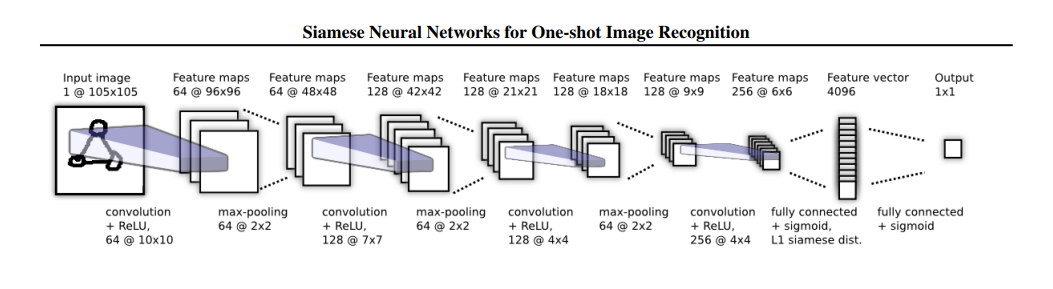

In [64]:
#inp = Input(shape =(105, 105, 3), name='input_image')

In [155]:
def make_embedding():

    #create a keras tensor input
    inp = Input(shape =(100, 100, 3), name='input_image')

    ## block one
    #creating convolutional layer with relu activation
    c1 = Conv2D(64,(10,10), activation= 'relu')(inp)
    #maxpooling layer with 2,2 slice
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    ## block two
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    ## block three
    c3 = Conv2D(128, (4,4), activation ='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    ## final block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    return Model(inputs= [inp], outputs=[d1], name='embedding')

In [156]:
emb = make_embedding()
emb.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

### Build Distance Layer


In [5]:
#siamese L1 distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Make Siamese Model

In [174]:
def make_simaese_model():
    #inputs
    input_image = Input(name='input_img', shape=(100,100,3))
    #validation input
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #combine siamese distance components
    simaese_layer = L1Dist()
    simaese_layer._name = 'distance'
    distances = simaese_layer(emb(input_image), emb(validation_image))

    #classification layer
    classifier = Dense(1, activation ='sigmoid')(distances)
    #return the created model
    return Model(inputs= [input_image, validation_image], outputs= classifier, name='siameseNetwork')


In [175]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_emb = emb(input_image)
val_emb = emb(validation_image)

In [176]:
simaese_layer = L1Dist()
distances = simaese_layer(emb(input_image), emb(validation_image))
classifier = Dense(1, activation ='sigmoid')(distances)
sae= Model(inputs= [input_image, validation_image], outputs= classifier, name='siameseNetwork')
sae.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [177]:
siamese_model = make_simaese_model()
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Training
#### Setup Loss and Optimizer

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy() # for binary classification
opt = tf.keras.optimizers.Adam(1e-4) # learning_rate = 0.0001


#### Establish Checkpoints

In [137]:
#to reload from checkpoint we can use model.load("path")
#this will load pre-trained weights

checkpoint_dir = './trainning_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt= opt, siamese_model=siamese_model)


#### Build Train Step Function
##### basic steps:
- make a prediction
- calculate loss
- derive gradients
- calculate new weights and apply


In [131]:

bat = train_data.as_numpy_iterator()
b1 = bat.next()
print(len(b1[1]))

16


In [179]:
#Compiles a function into a callable TensorFlow graph.
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #extracting anchor image and positive/negatice image
        #each batch is 16 images
        X = batch[:2]
        #y is labeled for images (16)
        y = batch[2]

        #forward prop
        #some layers will be activated only if training = true
        # x is our input ( two images ) [anchor(16), pos/neg(16)]
        yhat = siamese_model(X, training =True)

        #calculate loss
        #get two arg true Y and Y predicted(yhat)
        loss = binary_cross_loss(y, yhat)
        print(loss)
    #Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #update weights and apply them to model using adam optimizer
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss





### build training loop


In [180]:
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        #loop through each batch
        #getting each batch and its index
        for idx, batch in enumerate(data):

            #run train step for each batch
            loss = train_step(batch)
            progbar.update(idx+1)
        print(f"loss : {loss.numpy()}")

        #save checkpoints
        if epoch %10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)



## Train the model


In [181]:
EPOCHS = 50

In [182]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 7s 179ms/step
loss : 0.037799444049596786

 Epoch 2/50
27/27 [==============================] - 5s 173ms/step
loss : 0.1337312012910843

 Epoch 3/50
27/27 [==============================] - 4s 170ms/step
loss : 0.05705437809228897

 Epoch 4/50
27/27 [==============================] - 4s 169ms/step
loss : 0.0636119395494461

 Epoch 5/50
27/27 [==============================] - 4s 167ms/step
loss : 0.4107329249382019

 Epoch 6/50
27/27 [==============================] - 4s 167ms/step
loss : 0.005096542648971081

 Epoch 7/50
27/27 [==============================] - 4s 166ms/step
loss : 0.007936959154903889

 Epoch 8/50
27/27 [==============================] - 4s 163ms/step
loss : 0.21103015542030334

 Epoch 9/50
27/27 [==============================] - 4s 161ms/step
loss : 0.176260888

## Evaluate Model


In [81]:
#import precision and recall
from tensorflow.keras.metrics import Recall, Precision

In [82]:
#next batch
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(y_true)

[0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]


In [ ]:
for i in range(200):
  test_input, test_val, y_true = test_data.as_numpy_iterator().next()
  for j in range(16):
    if y_true[j] == 0 :
      print(y_true)

## Make predictions

In [48]:
## make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[8.3685190e-05],
       [9.9982190e-01],
       [9.9943316e-01],
       [1.6430911e-06],
       [1.0000000e+00],
       [1.0987752e-06],
       [1.6972972e-05],
       [1.4853475e-05],
       [9.9999475e-01],
       [1.9869716e-05],
       [2.3137886e-07],
       [1.0000000e+00],
       [2.5293767e-07],
       [9.9956024e-01],
       [9.3387280e-06],
       [2.7284674e-08]], dtype=float32)

In [168]:
# better intuation
print(len(y_true))
print(y_true)

16
[0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.]


In [185]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]

In [186]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [187]:
#creatingin metric object
m = Recall()
#calculating the recall value
m.update_state(y_true, y_hat)
#return result
m.result().numpy()

1.0

In [188]:
#creatingin metric object
m = Precision()
#calculating the Precision value
m.update_state(y_true, y_hat)
#return result
m.result().numpy()

1.0

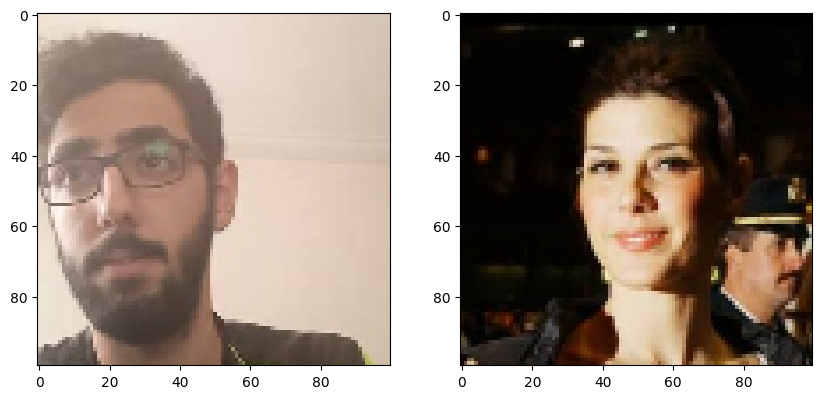

In [191]:
#plot size
plt.figure(figsize=(10,8))
#row, col, index
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
#render cleanly
plt.show()

## Save Model

In [192]:
#save our model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy')
siamese_model.save('siamesemodel.h5')

## Load Model

In [6]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodel.h5',  custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [199]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 179ms/step


array([[[[0.8862745 , 0.8509804 , 0.8156863 ],
         [0.8862745 , 0.8509804 , 0.8156863 ],
         [0.8862745 , 0.8509804 , 0.8156863 ],
         ...,
         [0.78431374, 0.7607843 , 0.7137255 ],
         [0.78357846, 0.75416666, 0.71004903],
         [0.7872549 , 0.7558824 , 0.70490193]],

        [[0.88235295, 0.84705883, 0.8117647 ],
         [0.88235295, 0.84705883, 0.8117647 ],
         [0.88235295, 0.84705883, 0.8117647 ],
         ...,
         [0.78210783, 0.75514704, 0.70980394],
         [0.78112745, 0.7497549 , 0.70661765],
         [0.78333336, 0.7519608 , 0.7029412 ]],

        [[0.8784314 , 0.84313726, 0.80784315],
         [0.8784314 , 0.84313726, 0.80784315],
         [0.8784314 , 0.84313726, 0.80784315],
         ...,
         [0.78112745, 0.7497549 , 0.70661765],
         [0.7767157 , 0.74534315, 0.7022059 ],
         [0.7794118 , 0.7480392 , 0.70490193]],

        ...,

        [[0.38284314, 0.3632353 , 0.34754902],
         [0.37720588, 0.35759804, 0.33995098]

In [71]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [200]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

### Saving the dataset for future use 

In [206]:
os.makedirs("/content/dataset")

In [212]:
data.save("/content/dataset")

In [7]:
path = 'C:/Users/Kp/Documents/HandWrittenRecognation/faceRecognition/dataset'

In [8]:
#loading data
data = tf.data.Dataset.load(path)

In [9]:
data

<_LoadDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

## Verification

In [21]:
os.makedirs('/content/Application_data')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/content/Application_data'

In [18]:
os.makedirs('/content/Application_data/verification_images')
os.makedirs('/content/Application_data/input_images')


In [10]:
def verify(model, detection_treshold, verificatoin_treshold):
  #build result array
  results = []
  #getting all the path to verification data and loop through it
  for image in os.listdir(os.path.join('Application_data', 'verification_images')):
    input_img = preprocess(os.path.join('Application_data', 'input_image', "input_image.jpg"))
    validation_img = preprocess((os.path.join('Application_data', 'verification_images', image)))
    res = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    print(f"res is : {res}")
    results.append(res)

  #Detection Treshold : Metric above which a prediction is considered positive
  detection = np.sum(np.array(results)> detection_treshold)
  print(f"detection: {detection}")
  #Verificatiqon Treshold: Proportion of positive predictions / total positive samples for example 30/50
  verification = detection / len(os.listdir(os.path.join('Application_data','verification_images')))
  print(f"verification : {verification}")
  verified = verification > verificatoin_treshold
  return results, verified


In [9]:
INP_PATH = 'C:/Users/Kp/Documents/HandWrittenRecognation/faceRecognition/Application_data/input_image/input_image.jpg'
#print(os.path.join('Application_data', 'input_'))

### OpenCv Real Time Verification

In [31]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
     #cut down image to 250pxa * 250px (the size of our dataset)
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('verification', frame )
    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to its folder
        cv2.imwrite(INP_PATH, frame)
        #run verification 
        #it should return prediction above 0.9 for each picture and should pass like 35 out of 50 images to get true
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 171ms/step
res is : [[1.]]
1/1 [==============================] - 0s 168ms/step
res is : [[1.]]
1/1 [==============================] - 0s 170ms/step
res is : [[1.]]
1/1 [==============================] - 0s 200ms/step
res is : [[1.]]
1/1 [==============================] - 0s 168ms/step
res is : [[1.]]
1/1 [==============================] - 0s 169ms/step
res is : [[1.]]
1/1 [==============================] - 0s 168ms/step
res is : [[1.]]
1/1 [==============================] - 0s 171ms/step
res is : [[1.]]
1/1 [==============================] - 0s 170ms/step
res is : [[1.]]
1/1 [==============================] - 0s 169ms/step
res is : [[1.]]
1/1 [==============================] - 0s 173ms/step
res is : [[1.]]
1/1 [==============================] - 0s 178ms/step
res is : [[1.]]
1/1 [==============================] - 0s 180ms/step
res is : [[1.]]
1/1 [==============================] - 0s 168ms/step
res is : [[0.9991149]]
1/1 [======================

1/1 [==============================] - 0s 164ms/step
res is : [[1.]]
1/1 [==============================] - 0s 173ms/step
res is : [[0.99999994]]
1/1 [==============================] - 0s 168ms/step
res is : [[1.]]
1/1 [==============================] - 0s 169ms/step
res is : [[0.9889598]]
1/1 [==============================] - 0s 174ms/step
res is : [[0.9947683]]
1/1 [==============================] - 0s 174ms/step
res is : [[0.5631284]]
1/1 [==============================] - 0s 176ms/step
res is : [[1.]]
1/1 [==============================] - 0s 178ms/step
res is : [[0.99999994]]
1/1 [==============================] - 0s 168ms/step
res is : [[1.]]
1/1 [==============================] - 0s 163ms/step
res is : [[0.99999994]]
1/1 [==============================] - 0s 163ms/step
res is : [[0.43174925]]
1/1 [==============================] - 0s 167ms/step
res is : [[0.3757349]]
1/1 [==============================] - 0s 178ms/step
res is : [[0.9214494]]
1/1 [==============================]

In [33]:
print(np.sum(results))

47.704884


### positive verification test


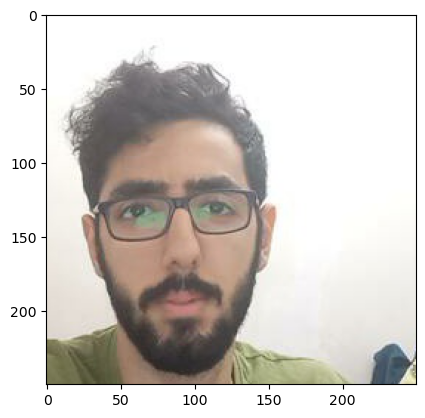

In [36]:
#plt.imshow(INP_PATH)
image = plt.imread(INP_PATH)
plt.imshow(image)

### negative verification test

In [13]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
     #cut down image to 250pxa * 250px (the size of our dataset)
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('verification', frame )
    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to its folder
        cv2.imwrite(INP_PATH, frame)
        #run verification 
        #it should return prediction above 0.9 for each picture and should pass like 35 out of 50 images to get true
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 165ms/step
res is : [[5.230513e-07]]
1/1 [==============================] - 0s 169ms/step
res is : [[4.5282331e-07]]
1/1 [==============================] - 0s 170ms/step
res is : [[5.059782e-07]]
1/1 [==============================] - 0s 172ms/step
res is : [[4.2883656e-07]]
1/1 [==============================] - 0s 176ms/step
res is : [[4.7477343e-07]]
1/1 [==============================] - 0s 202ms/step
res is : [[4.7274344e-07]]
1/1 [==============================] - 0s 170ms/step
res is : [[4.817168e-07]]
1/1 [==============================] - 0s 170ms/step
res is : [[5.115428e-07]]
1/1 [==============================] - 0s 171ms/step
res is : [[2.8612868e-07]]
1/1 [==============================] - 0s 196ms/step
res is : [[2.9670448e-07]]
1/1 [==============================] - 0s 179ms/step
res is : [[2.9265968e-07]]
1/1 [==============================] - 0s 171ms/step
res is : [[2.4274698e-07]]
1/1 [==============================] - 0s 17

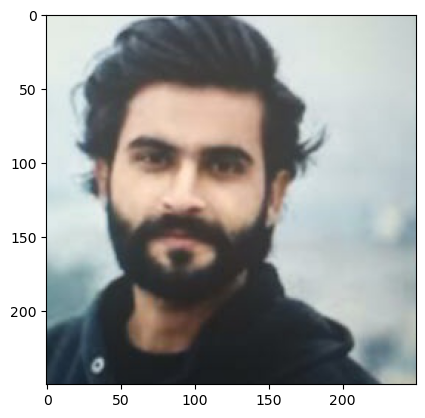

In [12]:
#plt.imshow(INP_PATH)
image = plt.imread(INP_PATH)
plt.imshow(image)
##false

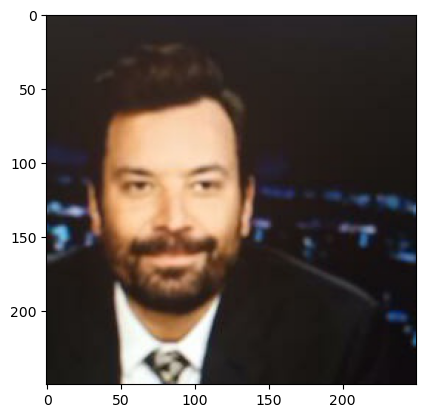

In [16]:
#plt.imshow(INP_PATH)
image = plt.imread(INP_PATH)
plt.imshow(image)
## false example